# Assignment 1: Human Activity Recognition

Authors:  
Lorenzo Lucchini


## Imports

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import tensorflow as tf
import xgboost as xgb
import itertools
import utility_functions as utilsFun
import sys


import warnings 
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix



## Load data

I will create single file with clean data, this will done by merging of all the subjects from the downloaded data and removing the ecg measuraments as stated in the readme file, "2-lead ECG measurements which are not used for the development of the recognition model but rather collected for future work purposes".

In [14]:
combined_df = pd.DataFrame()

# Merge all subject into a single one
for i in range(1, 11):
    df = pd.read_csv(f'MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df = df.loc[:, [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]].rename(columns= {
        0: 'chest_acc_x', 
        1: 'chest_acc_y', 
        2: 'chest_acc_z',
        3: 'elect_si_1',
        4: 'elect_si_2',
        5: 'lank_acc__x', 
        6: 'lank_acc__y',
        7: 'lank_acc__z', 
        8: 'lank_gyr_x',
        9: 'lank_gyr_y', 
        10: 'lank_gyr_z', 
        11: 'mag_lank_x', 
        12: 'mag_lank_y', 
        13: 'mag_lank_z', 
        14: 'rlowarm_acc_x', 
        15: 'rlowarm_acc_y',
        16: 'rlowarm_acc_z', 
        17: 'rlowarm_gyr_x', 
        18: 'rlowarm_gyr_y', 
        19: 'rlowarm_gyr_z', 
        20: 'mag_rlowarm_x', 
        21: 'mag_rlowarm_y', 
        22: 'mag_rlowarm_z',
        23: 'activity'
    })
    df['subject'] = f'subject{i}'
    combined_df = pd.concat([combined_df, df])

combined_df.to_csv('ProcessedData/allActivityMerged.csv', index=False)

the activity codes are:

L1: Standing still (1 min)

L2: Sitting and relaxing (1 min) 

L3: Lying down (1 min) 

L4: Walking (1 min) 

L5: Climbing stairs (1 min) 

L6: Waist bends forward (20x) 

L7: Frontal elevation of arms (20x)

L8: Knees bending (crouching) (20x)

L9: Cycling (1 min)

L10: Jogging (1 min)

L11: Running (1 min)

L12: Jump front & back (20x)

Since I'm assuming that code 0 for activity doesn't have an impact in the prediction of the activities as required by the task (as it doesnt have an activity label), I will also create a new file with only activities with values from 1 to 12. 

In [17]:

# Remove rows where 'activity' column has value 0
filteredActivity_df = combined_df[combined_df['activity'] != 0]  # Filter activity 0
filteredActivity_df.to_csv('ProcessedData/filteredActivityMerged.csv', index=False)

## Data Visualization

Visualize the data to identify possible changes required

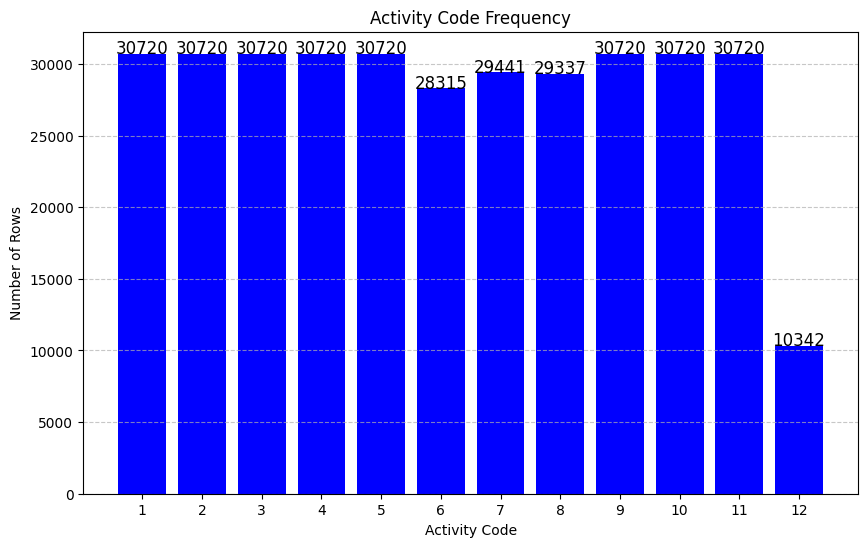

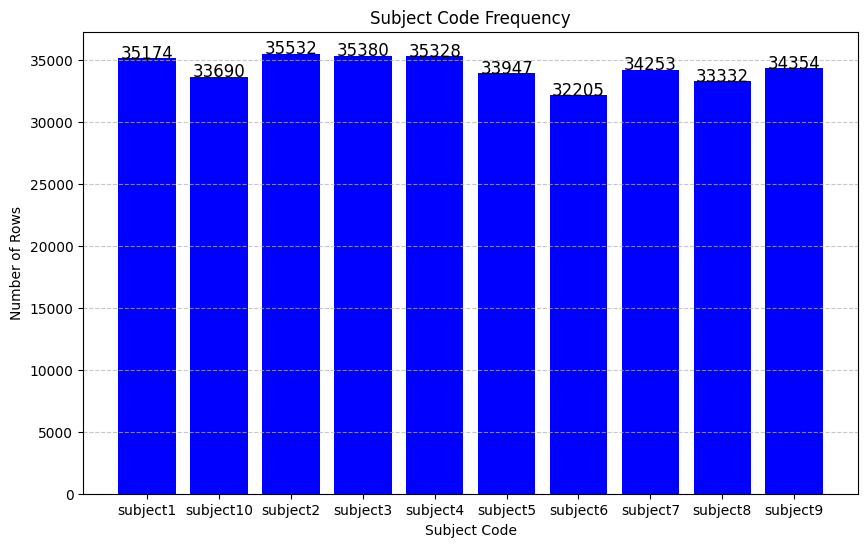

In [4]:
# Load data from file
df_display = pd.read_csv('ProcessedData/filteredActivityMerged.csv')

utilsFun.plot_activity_counts(df_display)
utilsFun.plot_subject_counts(df_display)



Lets start to check for correlation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343195 entries, 0 to 343194
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   chest_acc_y    343195 non-null  float64
 1   chest_acc_z    343195 non-null  float64
 2   lank_acc__x    343195 non-null  float64
 3   lank_acc__y    343195 non-null  float64
 4   lank_acc__z    343195 non-null  float64
 5   lank_gyr_x     343195 non-null  float64
 6   lank_gyr_y     343195 non-null  float64
 7   lank_gyr_z     343195 non-null  float64
 8   mag_lank_x     343195 non-null  float64
 9   mag_lank_y     343195 non-null  float64
 10  mag_lank_z     343195 non-null  float64
 11  rlowarm_acc_x  343195 non-null  float64
 12  rlowarm_acc_y  343195 non-null  float64
 13  rlowarm_acc_z  343195 non-null  float64
 14  rlowarm_gyr_x  343195 non-null  float64
 15  rlowarm_gyr_y  343195 non-null  float64
 16  rlowarm_gyr_z  343195 non-null  float64
 17  mag_rlowarm_x  343195 non-nul

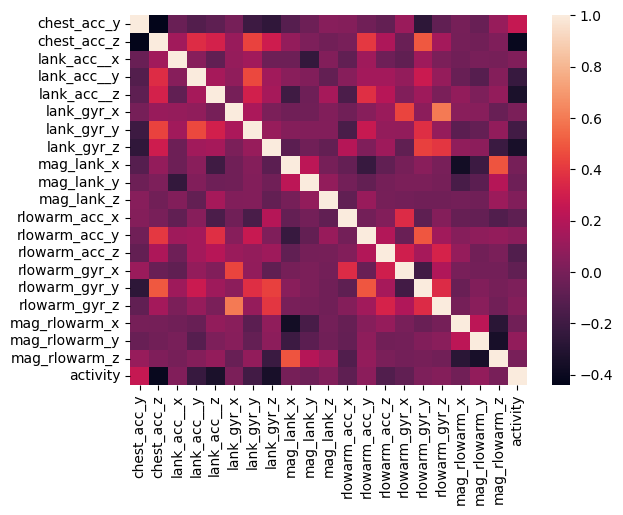

In [18]:
data = pd.read_csv('ProcessedData/filteredActivityMerged.csv')

data = data.iloc[:,1:-1]
data.info()
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

corr = data.corr()
sns.heatmap(corr)


columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data_corr = data[selected_columns]
data_corr.info()

After checking for sampling and correlation, the columns seem to be un correlated. However the sampling size sees a large difference for activity type but similar sampling for subject. I will therefore create an oversampling for activities 6, 7, 8, and 12

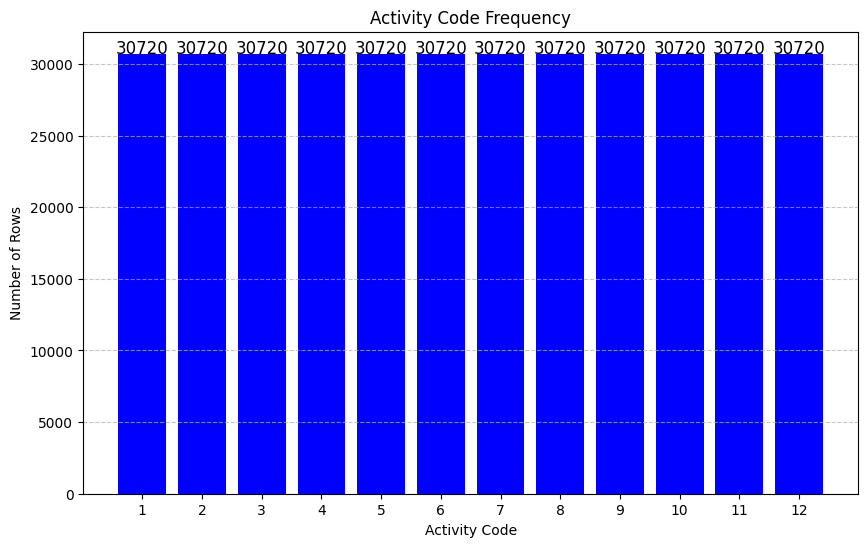

In [19]:
# Load dataset
filteredData_df = pd.read_csv('ProcessedData/filteredActivityMerged.csv')

fullActivityMerged_df = filteredData_df.drop(columns=['subject'])

fullActivityMerged_df.to_csv('ProcessedData/fullActivityMerged.csv', index=False)


# Separate features and target
X = filteredData_df.drop(columns=['activity'])  # Features
y = filteredData_df['activity']  # Target (activity)

# Define the sampling strategy
# Only upsample activities 0, 6, 7, and 8 to 30,720 samples, keeping others unchanged
target_counts = {label: count for label, count in Counter(y).items()}  # Keep existing counts
for target_class in [6, 7, 8, 12]:
    if target_counts.get(target_class, 0) < 30720:  # Only oversample if needed
        target_counts[target_class] = 30720

# Apply RandomOverSampler
ros = RandomOverSampler(sampling_strategy=target_counts, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


# Create new DataFrame with resampled data
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['activity'] = y_resampled

df_resampled = df_resampled.drop(columns=['subject'])

# Save the new balanced dataset
df_resampled.to_csv('ProcessedData/oversampledActivityMerged.csv', index=False)

utilsFun.plot_activity_counts(df_resampled)


Since the use of oversampling might cuase overfitting I will have to keep this in mind during the model training.
Now we have a clean data set that can be used to start training the chosen models.

In [20]:
print("The file contains: " + str(len(df_display))+ " rows")

The file contains: 343195 rows


Since the file of data produced contains more then 300 000 rows, the data set is quite large. Furthermore the goal of our task is to achive classification of movement. Also the data is a structured tabular data. For these reasons, according to what we have learned during the lectures the best model should be:  XGBoost, another good fit for this model could be random forest, and finally I might try to create an ensamble model and see if there are any important differences.

## Task 1 Prediction

### Develop a model that can accurately predict the activity based on features. If you use multiple models, report the accuracy (or other relevant score) for all models and motivate which model works best. Note that different models might work better for different activities. This motivates steps 2 and 3.
### I'll be using MHEALTH dataset: classes are the activities

### Splitting data set and Model definitions

As stated before my data set is vulnerable to overfitting, and I will therefore use the k-fold validation method to try and avoid this as much as possible. 

In [21]:
# Split features and target
final_df = pd.read_csv("ProcessedData/oversampledActivityMerged.csv")
X = final_df.drop(columns=["activity"])  
y = final_df["activity"]
y = y - 1 # I need to do this as the XGBClassifier expects a starting index of 0 and i have it at 1

# Split into validate, train and test sets with 10 20 and 70 percent of data accordingly
# Step 1: Create the validation set (10% of the data)
X_train_test, X_val, y_train_test, y_val = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Step 2: Split the remaining 90% into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_train_test, y_train_test, test_size=0.2222, stratify=y_train_test, random_state=42
)
#I will no use kfold to split the training data into validation as well
kf = KFold(n_splits=4, shuffle=True, random_state=42)


The first Model I will test is  XGBoost, i will save the model produced in the Models folder

Training XGBoost with max_depth=2 using 4-Fold CV...
Max Depth: 2 | Mean Accuracy: 0.8729
Max Depth: 2 | Mean Validation Loss: 0.6404
Training XGBoost with max_depth=3 using 4-Fold CV...
Max Depth: 3 | Mean Accuracy: 0.9245
Max Depth: 3 | Mean Validation Loss: 0.3991
Training XGBoost with max_depth=4 using 4-Fold CV...
Max Depth: 4 | Mean Accuracy: 0.9516
Max Depth: 4 | Mean Validation Loss: 0.2713
Training XGBoost with max_depth=5 using 4-Fold CV...
Max Depth: 5 | Mean Accuracy: 0.9713
Max Depth: 5 | Mean Validation Loss: 0.1886
Training XGBoost with max_depth=6 using 4-Fold CV...
Max Depth: 6 | Mean Accuracy: 0.9830
Max Depth: 6 | Mean Validation Loss: 0.1318
Training XGBoost with max_depth=7 using 4-Fold CV...
Max Depth: 7 | Mean Accuracy: 0.9893
Max Depth: 7 | Mean Validation Loss: 0.0943
Training XGBoost with max_depth=8 using 4-Fold CV...
Max Depth: 8 | Mean Accuracy: 0.9928
Max Depth: 8 | Mean Validation Loss: 0.0697
Training XGBoost with max_depth=9 using 4-Fold CV...
Max Depth

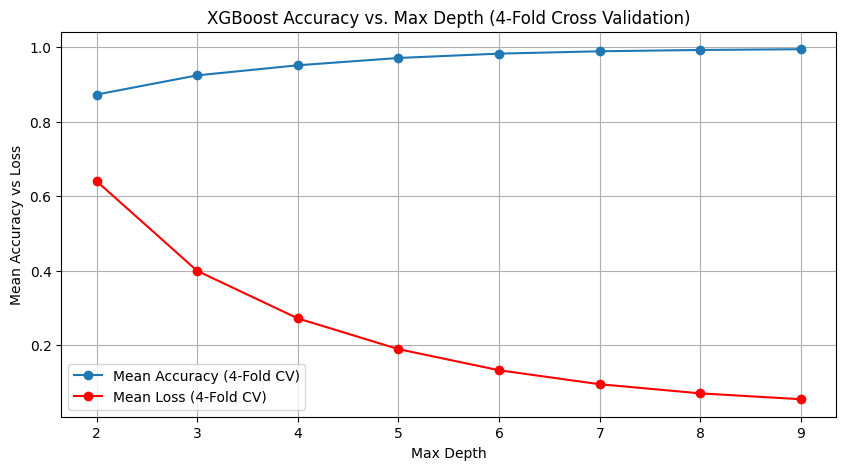

Best max_depth found: 9


In [22]:
depth_scores = []
loss_scores = [] 

# Loop through different max_depth values (from 2 to 8)
for i in range(2, 10):
    print(f"Training XGBoost with max_depth={i} using 4-Fold CV...")

   # Define the XGBoost model with regularization
    xgb_model = xgb.XGBClassifier(
        max_depth=i,  # Reduce complexity
        n_estimators=100,  # Lower number of trees
        learning_rate=0.05,  # Slower learning for better generalization
        subsample=0.8,  # Prevents overfitting
        colsample_bytree=0.8,  # Prevents reliance on a single feature
        reg_alpha=0.1,  # L1 Regularization (Lasso)
        reg_lambda=0.1,  # L2 Regularization (Ridge)
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss",
    )
    
    scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring="accuracy")
    valLossScore = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring="neg_log_loss")

    # Store depth and mean accuracy
    depth_scores.append((i, scores.mean()))
    loss_scores.append((i, -valLossScore.mean()))

    print(f"Max Depth: {i} | Mean Accuracy: {scores.mean():.4f}")
    print(f"Max Depth: {i} | Mean Validation Loss: {-valLossScore.mean():.4f}")


# Convert results to DataFrame
df_depth = pd.DataFrame(depth_scores, columns=["max_depth", "accuracy"])
df_depth_loss = pd.DataFrame(loss_scores, columns=["max_depth", "neg_log_loss"])

# Plot Accuracy vs. Max Depth
plt.figure(figsize=(10, 5))
plt.plot(df_depth["max_depth"], df_depth["accuracy"], marker="o", linestyle="-", label="Mean Accuracy (4-Fold CV)")
plt.plot(df_depth_loss["max_depth"], df_depth_loss["neg_log_loss"], marker="o",color="r", linestyle="-", label="Mean Loss (4-Fold CV)")
plt.xlabel("Max Depth")
plt.ylabel("Mean Accuracy vs Loss")
plt.title("XGBoost Accuracy vs. Max Depth (4-Fold Cross Validation)")
plt.legend()
plt.grid(True)
plt.show()

# Find the best max_depth
best_depth = df_depth.loc[df_depth["accuracy"].idxmax(), "max_depth"]
print(f"Best max_depth found: {best_depth}")

Even though the best max_depth found was 9, it is also true that the risk of overfitting is too high at that depth, as can be seen by the very low mean validation loss in red. For this reason I believe the choiches that work best are 4, 5 and 6. However the increase in accuracy between depth of 5 and 6 is quite low, and I therefore chose to go with a max depth of 5, as a score above 90% is extremely good.

In [23]:
# Create the final model of xgb
final_xgb = xgb.XGBClassifier(
    max_depth=5,  
    n_estimators=100,  
    learning_rate=0.05,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    reg_alpha=0.1,  
    reg_lambda=0.1,  
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

# Train on full training data
final_xgb.fit(X_train, y_train)

# Predict on test data
y_xgb_pred_test = final_xgb.predict(X_test)

# Evaluate final model performance
xgb_test_accuracy = accuracy_score(y_test, y_xgb_pred_test)


In [24]:
print(xgb_test_accuracy)

0.9709852009603777


The value 0.97 seems to be an overfitting. In fact I chose to use oversampling to bring the activity 12 on pair with all other activities, so i want to make sure that is not the reason for the overfitting. To do this I will also train the same model on the orginal set without oversampling and compare the results with a function created with deepseek

In [ ]:
# Load Original Dataset (Before Oversampling)
df_original = pd.read_csv("ProcessedData/fullActivityMerged.csv")

# Load Oversampled Dataset
df_oversampled = pd.read_csv("ProcessedData/oversampledActivityMerged.csv")

# Prepare Features & Labels for Both Datasets
X_original = df_original.drop(columns=["activity"])
y_original = df_original["activity"] - 1  # Shift labels to start from 0

X_oversampled = df_oversampled.drop(columns=["activity"])
y_oversampled = df_oversampled["activity"] - 1  # Shift labels to start from 0

# Split Data (Original)
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, stratify=y_original, random_state=42
)

# Split Data (Oversampled)
X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(
    X_oversampled, y_oversampled, test_size=0.2, stratify=y_oversampled, random_state=42
)

# Initialize XGBoost Model
xgb_params = {
    "max_depth": 5,
    "n_estimators": 100,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "reg_alpha":0.1,  # L1 Regularization (Lasso)
    "reg_lambda":0.1,  # L2 Regularization (Ridge)
    "use_label_encoder": False,
    "eval_metric": "mlogloss"
}

# Train on Original Data
xgb_original = xgb.XGBClassifier(**xgb_params)
xgb_original.fit(X_train_original, y_train_original)

# Train on Oversampled Data
xgb_oversampled = xgb.XGBClassifier(**xgb_params)
xgb_oversampled.fit(X_train_oversampled, y_train_oversampled)

# Predictions on Test Sets
y_pred_original = xgb_original.predict(X_test_original)
y_pred_oversampled = xgb_oversampled.predict(X_test_oversampled)

# Accuracy Comparison
train_acc_original = accuracy_score(y_train_original, xgb_original.predict(X_train_original))
test_acc_original = accuracy_score(y_test_original, y_pred_original)

train_acc_oversampled = accuracy_score(y_train_oversampled, xgb_oversampled.predict(X_train_oversampled))
test_acc_oversampled = accuracy_score(y_test_oversampled, y_pred_oversampled)

print(f"\n🔹 Train & Test Accuracy (Original Data)")
print(f"Train Accuracy (Before Oversampling): {train_acc_original:.4f}")
print(f"Test Accuracy (Before Oversampling): {test_acc_original:.4f}")

print(f"\n🔹 Train & Test Accuracy (Oversampled Data)")
print(f"Train Accuracy (After Oversampling): {train_acc_oversampled:.4f}")
print(f"Test Accuracy (After Oversampling): {test_acc_oversampled:.4f}")

# Check for Overfitting (Train vs Test Accuracy Difference)
overfitting_original = train_acc_original - test_acc_original
overfitting_oversampled = train_acc_oversampled - test_acc_oversampled

print(f"\n⚠️ Overfitting Difference (Original Data): {overfitting_original:.4f}")
print(f"⚠️ Overfitting Difference (Oversampled Data): {overfitting_oversampled:.4f}")

# F1-Score Comparison
print("\n🔹 Classification Report (Original Data):")
print(classification_report(y_test_original, y_pred_original))

print("\n🔹 Classification Report (Oversampled Data):")
print(classification_report(y_test_oversampled, y_pred_oversampled))


🔹 Train & Test Accuracy (Original Data)
Train Accuracy (Before Oversampling): 0.9740
Test Accuracy (Before Oversampling): 0.9719

🔹 Train & Test Accuracy (Oversampled Data)
Train Accuracy (After Oversampling): 0.9739
Test Accuracy (After Oversampling): 0.9719

⚠️ Overfitting Difference (Original Data): 0.0021
⚠️ Overfitting Difference (Oversampled Data): 0.0020

🔹 Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6144
           1       1.00      1.00      1.00      6144
           2       1.00      1.00      1.00      6144
           3       0.96      0.99      0.97      6144
           4       0.97      0.93      0.95      6144
           5       0.96      0.96      0.96      5663
           6       0.98      0.98      0.98      5888
           7       0.95      0.95      0.95      5868
           8       1.00      1.00      1.00      6144
           9       0.95      0.93      0.94      614

The 

⚠️ Overfitting Difference (Original Data): 0.0021

⚠️ Overfitting Difference (Oversampled Data): 0.0020


seems to display that there is very little overfitting difference in the two models, I will now create a classification_report to check the rest of the evaluation variables:

In [33]:
print(classification_report(y_test, y_xgb_pred_test))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6143
           1       1.00      1.00      1.00      6143
           2       1.00      1.00      1.00      6143
           3       0.96      0.98      0.97      6144
           4       0.97      0.93      0.95      6144
           5       0.97      0.96      0.97      6143
           6       0.98      0.98      0.98      6144
           7       0.95      0.95      0.95      6144
           8       1.00      1.00      1.00      6143
           9       0.96      0.92      0.94      6143
          10       0.92      0.96      0.94      6143
          11       0.97      0.97      0.97      6144

    accuracy                           0.97     73721
   macro avg       0.97      0.97      0.97     73721
weighted avg       0.97      0.97      0.97     73721



The model seems to be extremely accurate on all evaluation matrix.
I will therefore save this model to the models folder

In [27]:
joblib.dump(final_xgb, "Models/xgboost_model.pkl")

['Models/xgboost_model.pkl']

The second Model I will test is the RandomForestClassifier, i will mantain the same parameters as the xgboost to see how they compare


In [29]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,  # Limit tree depth to prevent overfitting
    min_samples_split=5,  # Minimum samples required to split
    min_samples_leaf=2,  # Minimum samples in a leaf node
    random_state=42,
    n_jobs=-1  # Use all available cores for training
)

# Perform Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="accuracy")

# Print Cross-Validation Results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean Accuracy across folds: {np.mean(cv_scores):.4f}")

Cross-validation accuracy scores: [0.80568559 0.80351552 0.80681712 0.80143537]
Mean Accuracy across folds: 0.8044


In [30]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=9,  # Limit tree depth to prevent overfitting
    min_samples_split=5,  # Minimum samples required to split
    min_samples_leaf=2,  # Minimum samples in a leaf node
    random_state=42,
    n_jobs=-1  # Use all available cores for training
)

# Perform Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="accuracy")

# Print Cross-Validation Results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean Accuracy across folds: {np.mean(cv_scores):.4f}")


Cross-validation accuracy scores: [0.92322597 0.92274545 0.92770561 0.92386031]
Mean Accuracy across folds: 0.9244


The difference in accuracy is quite high, the random forest being much lower in the accuracy. In order to achive similar accuracy the randomforest classifier needs a depth of 9 which however is extremely prone to overfitting. I will therefore define the xgboost as the better model for this task.
I will still use the Radom Forest with a depth of 5 for my ensamble model.


In [31]:

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,  # Limit tree depth to prevent overfitting
    min_samples_split=5,  # Minimum samples required to split
    min_samples_leaf=2,  # Minimum samples in a leaf node
    random_state=42,
    n_jobs=-1  # Use all available cores for training
)

# Train on full training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_rf_pred_test = rf_model.predict(X_test)

# Evaluate final model performance
rf_test_accuracy = accuracy_score(y_test, y_rf_pred_test)

print(rf_test_accuracy)

0.8054963985838499


Now I will check if an ensable would make a difference 

In [34]:
# Define Random Forest Model
ensable_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Define XGBoost Model
ensable_xgb_model = xgb.XGBClassifier(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    reg_alpha=0.1,  # L1 Regularization (Lasso)
    reg_lambda=0.1,  # L2 Regularization (Ridge)
    eval_metric="mlogloss"
)

# Create Voting Classifier with both models
ensemble_model = VotingClassifier(
    estimators=[('random_forest', ensable_rf_model), ('xgboost', ensable_xgb_model)],
    voting='soft'  # Use soft voting (probabilities) for better accuracy
)

cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=kf, scoring="accuracy")

# Print Cross-Validation Results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean Accuracy across folds: {np.mean(cv_scores):.4f}")



# Train on full training data
ensemble_model.fit(X_train, y_train)

# Predict on test data
y_ensable_pred_test = ensemble_model.predict(X_test)

# Evaluate final model performance
ensamble_test_accuracy = accuracy_score(y_test, y_ensable_pred_test)

Cross-validation accuracy scores: [0.98696407 0.98733608 0.98752209 0.98673136]
Mean Accuracy across folds: 0.9871


In [37]:
print(ensamble_test_accuracy)
print(classification_report(y_test, y_ensable_pred_test))


0.9875747751658279
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6143
           1       1.00      1.00      1.00      6143
           2       1.00      1.00      1.00      6143
           3       0.98      0.99      0.99      6144
           4       0.99      0.97      0.98      6144
           5       0.99      0.99      0.99      6143
           6       1.00      1.00      1.00      6144
           7       0.98      0.98      0.98      6144
           8       1.00      1.00      1.00      6143
           9       0.98      0.96      0.97      6143
          10       0.96      0.98      0.97      6143
          11       0.99      0.98      0.99      6144

    accuracy                           0.99     73721
   macro avg       0.99      0.99      0.99     73721
weighted avg       0.99      0.99      0.99     73721



The added complexity of ensable create a 0.1 increase in accuracy, and an overall increase in all evaluation matrix, if we analise the confusion matrix:

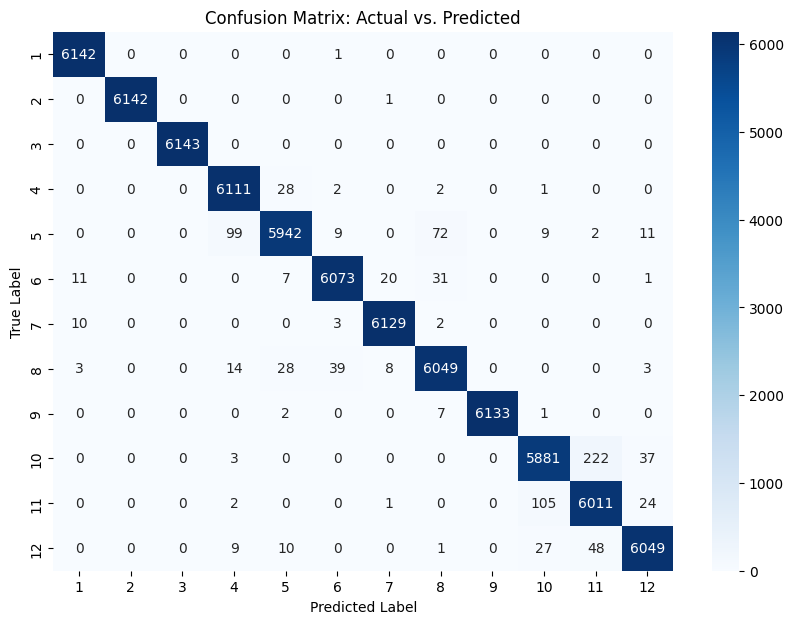

In [38]:
cm = confusion_matrix(y_test, y_ensable_pred_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Actual vs. Predicted")
plt.show()

we can see that the distribution seems to be quite great except for activities 5 and 8, with a larger alteration in 10 11 and 12.
The alteration seems therefore being in high intesinty activity, where jogging(10) gets interchanged for running(11), this makes a lot of sense as the only difference between the two is the running speed.
For the main error between climbing stars (5) and knees bending(8), this two activies share a lot of movement similarities to other activities so it makes sense that they would be classified with more confusion.

The model could be further optimised with a gradient boosting. But for now it seems to be great at it's classification.

In [39]:
joblib.dump(ensemble_model, "Models/ensemble_model.pkl")

['Models/ensemble_model.pkl']

## Task 2 Feature Engineering:

## Identify the minimal set of features (you might need to create or estimate other features from the dataset) that can predict each activity. You might find that different features predict different activities. 

Since the model I chose is the ensamble model I will have to first calculate which of the 21 feautures are the features mostly used in the xgb and rf models used in the ensamble, after which I can start removing features while the prediction accuracy doesnt vastly decrease.

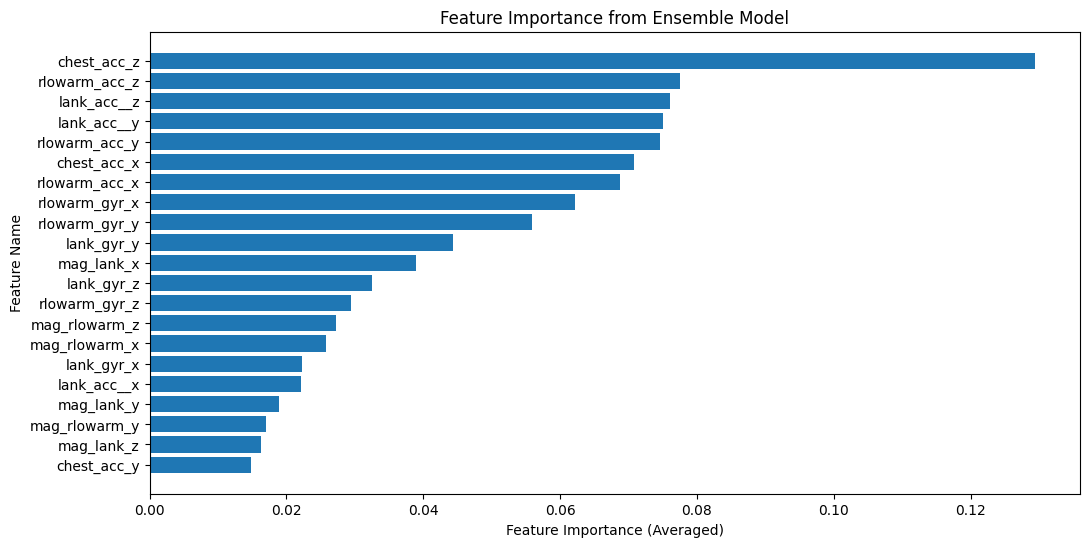

In [40]:
# Extract feature importance from XGBoost
xgb_importance = final_xgb.feature_importances_

# Extract feature importance from Random Forest
rf_importance = rf_model.feature_importances_


# Compute average feature importance
avg_importance = (xgb_importance + rf_importance) / 2


# Create a DataFrame for visualization
improtance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'XGBoost Importance': xgb_importance,
    'Random Forest Importance': rf_importance,
    'Average Importance': avg_importance
}).sort_values(by="Average Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(improtance_df['Feature'], improtance_df['Average Importance'])
plt.xlabel("Feature Importance (Averaged)")
plt.ylabel("Feature Name")
plt.title("Feature Importance from Ensemble Model")
plt.gca().invert_yaxis()  # Reverse order for better readability
plt.show()



The most important features seem to be the accelleration of teh right lower arm and the accelleration of the chest. I will further check the influence of these values on the model.

I will now create a new model containing the learning based on number of features to identify the breaking point for the minimum number of features for the prediction.

Features: 1 | Accuracy: 0.3570
Features: 2 | Accuracy: 0.5497
Features: 3 | Accuracy: 0.6540
Features: 4 | Accuracy: 0.7637
Features: 5 | Accuracy: 0.8049
Features: 6 | Accuracy: 0.8351
Features: 7 | Accuracy: 0.8554
Features: 8 | Accuracy: 0.8685
Features: 9 | Accuracy: 0.8803
Features: 10 | Accuracy: 0.9120
Features: 11 | Accuracy: 0.9222
Features: 12 | Accuracy: 0.9358
Features: 13 | Accuracy: 0.9439
Features: 14 | Accuracy: 0.9500
Features: 15 | Accuracy: 0.9553
Features: 16 | Accuracy: 0.9628


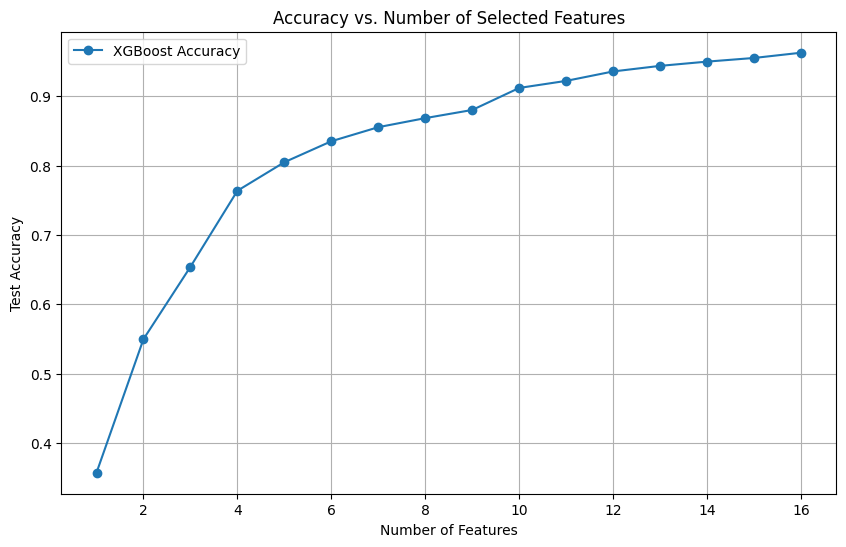

In [41]:
# Compute Feature Importance from XGBoost Model
xgb_full = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric="mlogloss"
    )

xgb_full.fit(X_train, y_train)

# Extract Feature Importance
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_full.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Compare Accuracy from 7 to 16 Features
feature_range = range(1, 17)  # Features from 7 to 16
accuracy_results = []

for num_features in feature_range:
    # Select the top `num_features`
    selected_features = importance_df["Feature"].head(num_features)
    
    # Train with selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    xgb_selected = xgb.XGBClassifier(
        max_depth=5,  
        n_estimators=100,
        learning_rate=0.05,  
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,  
        reg_lambda=0.1,  
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )
    
    xgb_selected.fit(X_train_selected, y_train)
    
    # Predict and evaluate accuracy
    y_pred_selected = xgb_selected.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred_selected)
    
    accuracy_results.append((num_features, accuracy))
    print(f"Features: {num_features} | Accuracy: {accuracy:.4f}")

# Convert results to DataFrame
accuracy_df = pd.DataFrame(accuracy_results, columns=["Num_Features", "Accuracy"])

# Plot Accuracy vs. Number of Features
plt.figure(figsize=(10, 6))
plt.plot(accuracy_df["Num_Features"], accuracy_df["Accuracy"], marker="o", linestyle="-", label="XGBoost Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs. Number of Selected Features")
plt.legend()
plt.grid(True)
plt.show()

The highest change in the accuracy of the model seems to be from 10 to 9 features. I will therefore retrain my ensable with 10 feauteres and check it's performance based on accuracy and confusion matrix

2       chest_acc_z
13    rlowarm_acc_y
12    rlowarm_acc_x
5       lank_acc__z
4       lank_acc__y
15    rlowarm_gyr_x
14    rlowarm_acc_z
0       chest_acc_x
18    mag_rlowarm_x
16    rlowarm_gyr_y
Name: Feature, dtype: object
0.9353915437934917


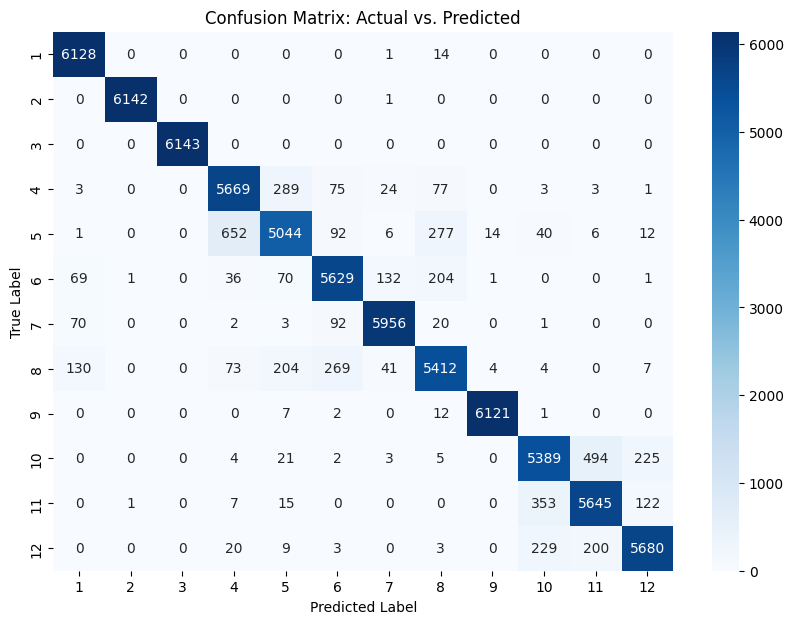

In [42]:

# Create Voting Classifier with both models
minimal_ensemble_model = VotingClassifier(
    estimators=[('random_forest', ensable_rf_model), ('xgboost', ensable_xgb_model)],
    voting='soft'  # Use soft voting (probabilities) for better accuracy
)
top_selected_features = importance_df["Feature"].head(10)
print(top_selected_features)



X_test_selected_10 = X_test[top_selected_features]
X_train_selected_10 = X_train[top_selected_features]


# Train ensemble on selected features
minimal_ensemble_model.fit(X_train_selected_10, y_train)

# Predict on test data
y_minimal_nsable_pred_test = minimal_ensemble_model.predict(X_test_selected_10)

# Evaluate final model performance
minimal_ensamble_test_accuracy = accuracy_score(y_test, y_minimal_nsable_pred_test)

print(minimal_ensamble_test_accuracy)

cm = confusion_matrix(y_test, y_minimal_nsable_pred_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Actual vs. Predicted")
plt.show()


The previous lack in accuracy on 5 8 and the 10 11 and 12 activities has greatly increased. However the model mantains a 94 percent accuracy on test data. I will now create a classification report to see weather using a gradient descent is worth the an eventual increase in precision.

In [43]:
print(classification_report(y_test, y_minimal_nsable_pred_test))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6143
           1       1.00      1.00      1.00      6143
           2       1.00      1.00      1.00      6143
           3       0.88      0.92      0.90      6144
           4       0.89      0.82      0.85      6144
           5       0.91      0.92      0.91      6143
           6       0.97      0.97      0.97      6144
           7       0.90      0.88      0.89      6144
           8       1.00      1.00      1.00      6143
           9       0.90      0.88      0.89      6143
          10       0.89      0.92      0.90      6143
          11       0.94      0.92      0.93      6144

    accuracy                           0.94     73721
   macro avg       0.94      0.94      0.94     73721
weighted avg       0.94      0.94      0.94     73721



Even with only 10 features, selected based on their average impact on the model, the accuracy is extremely high! With the main probles not only in accuracy but also in recall and f1 score being on the 5th activity. I will therefore save the new model in the model folder

In [44]:
joblib.dump(minimal_ensemble_model, "Models/minimal_ensemble_model.pkl")

['Models/minimal_ensemble_model.pkl']

# Task 3

## Use feature engineering to optimize sensor placement with 2 sensors and a single sensor.

Considering each data set of acc, gyro, emg or mag to be indipendent sensors, (this is due to the chest only having accelleration data, even though probably one sensor has both accelleration and gyro) I will now try to do something different, that is to figure out which combination of 2 sensors I can use to still have a good prediction (so which combination of acc, gyro, emg or mag data per placement offers the best accuracy). In order to do this, I will first group the sensors by their type and position, for example lower arm gyro scope (rlowarm_gyr) will contain all values on x, y and z planes, chest accellerometer (chest_acc) will contain all values on x, y and z planes and so on. After grouping all features I will train the model with a combination of those features and check the combination with the most accuracy.



Best feature group combination: ('rlowarm_gyr', 'lank_gyr') with accuracy: 0.9222
['rlowarm_gyr_x', 'rlowarm_gyr_y', 'rlowarm_gyr_z', 'lank_gyr_z', 'lank_gyr_y', 'lank_gyr_x']
0.9222338275389644


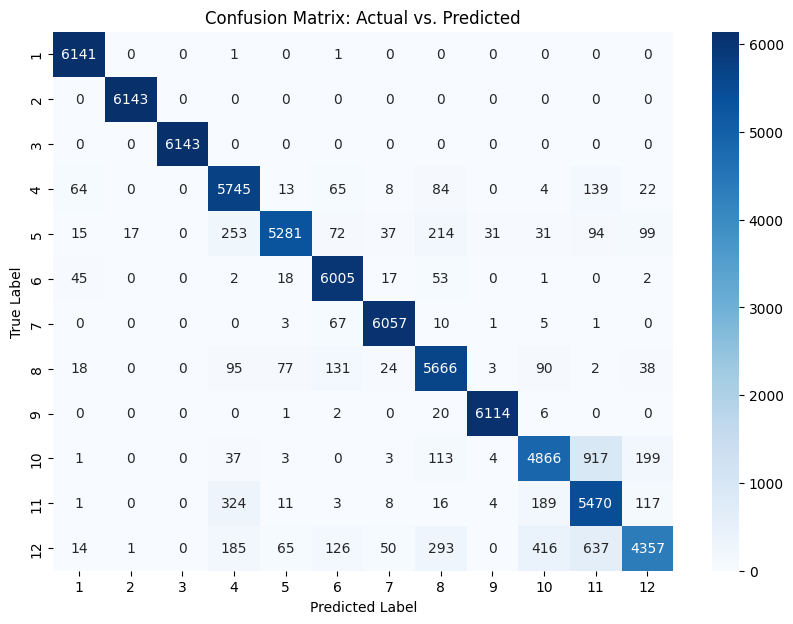

In [45]:
def find_best_feature_group_combination(importance_df, X_train, X_test, y_train, y_test, model):
    feature_groups = group_features_by_prefix(importance_df["Feature"].tolist())
    group_keys = list(feature_groups.keys())
    
    best_combination = None
    best_accuracy = 0
    
    for group1, group2 in itertools.combinations(group_keys, 2):
        selected_features = feature_groups[group1] + feature_groups[group2]
        
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = (group1, group2)
    
    print(f"Best feature group combination: {best_combination} with accuracy: {best_accuracy:.4f}")
    return best_combination


# Function to group features by first two parts of the name
def group_features_by_prefix(features):
    feature_groups = {}
    
    for feature in features:
        prefix = "_".join(feature.split("_")[:2])  # Extract first two parts
        if prefix not in feature_groups:
            feature_groups[prefix] = []
        feature_groups[prefix].append(feature)
    
    return feature_groups

# Apply feature group selection
best_groups = find_best_feature_group_combination(importance_df, X_train, X_test, y_train, y_test, minimal_ensemble_model)

# Train ensemble on selected groups
selected_features = group_features_by_prefix(importance_df["Feature"].tolist())[best_groups[0]] + \
                    group_features_by_prefix(importance_df["Feature"].tolist())[best_groups[1]]
print(selected_features)
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Create Voting Classifier with both models
Two_featured_ensemble_model = VotingClassifier(
    estimators=[('random_forest', ensable_rf_model), ('xgboost', ensable_xgb_model)],
    voting='soft'  # Use soft voting (probabilities) for better accuracy
)

Two_featured_ensemble_model.fit(X_train_selected, y_train)

# Predict on test data
y_minimal_ensable_pred_test = Two_featured_ensemble_model.predict(X_test_selected)

# Evaluate final model performance
Two_featured_minimal_ensemble_test_accuracy = accuracy_score(y_test, y_minimal_ensable_pred_test)
print(Two_featured_minimal_ensemble_test_accuracy)

cm = confusion_matrix(y_test, y_minimal_ensable_pred_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Actual vs. Predicted")
plt.show()


The model mantains an accuracy of 92 percent only using the gyroscope data from the left ankle and the right lower arm. This is still quite an accurate model as according to litterature 85% of accuracy is the threshold for a good model.
We can see the main confusion however is in the running, jogging and more improtantly the jumping back and forth, where probably the chest sensor would make a bigger impact. I therefore decided to try and plot the decision metrices for right lower arm gyro and left ankle gyro vs chest acceleration and left ankle gyro

Model 1 Accuracy (rlowarm_gyr & lank_gyr): 0.9222
Model 2 Accuracy (lank_gyr & chest_acc): 0.8985


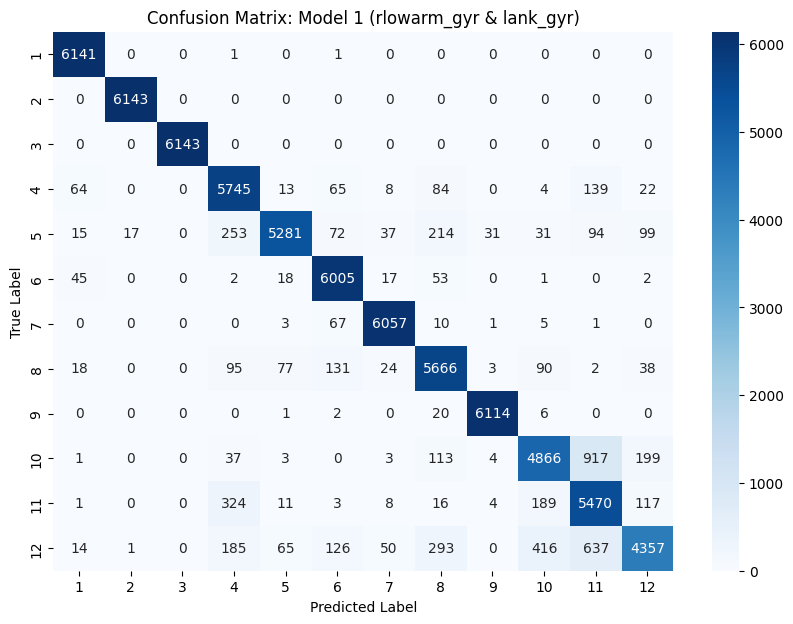

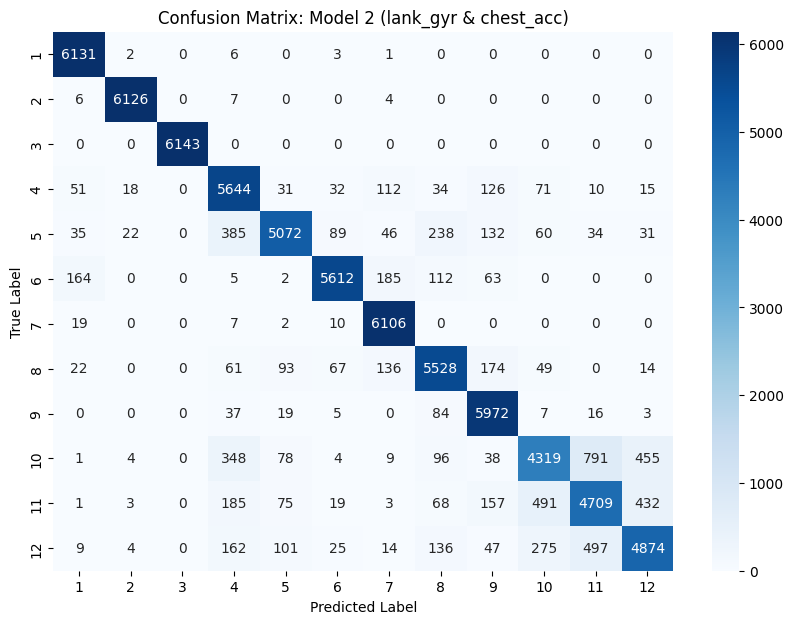

In [46]:


# Group features
feature_groups = utilsFun.group_features_by_prefix(importance_df["Feature"].tolist())

# Define selected feature groups for the two models
selected_features_1 = feature_groups.get("rlowarm_gyr", []) + feature_groups.get("lank_gyr", [])
selected_features_2 = feature_groups.get("lank_gyr", []) + feature_groups.get("chest_acc", [])

# Train first model with rlowarm_gyr and lank_gyr
X_train_selected_1 = X_train[selected_features_1]
X_test_selected_1 = X_test[selected_features_1]

minimal_ensemble_model_1 = VotingClassifier(
    estimators=[('random_forest', ensable_rf_model), ('xgboost', ensable_xgb_model)],
    voting='soft'
)

minimal_ensemble_model_1.fit(X_train_selected_1, y_train)
y_pred_1 = minimal_ensemble_model_1.predict(X_test_selected_1)
accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f"Model 1 Accuracy (rlowarm_gyr & lank_gyr): {accuracy_1:.4f}")

# Train second model with lank_gyr and chest_acc
X_train_selected_2 = X_train[selected_features_2]
X_test_selected_2 = X_test[selected_features_2]

minimal_ensemble_model_2 = VotingClassifier(
    estimators=[('random_forest', ensable_rf_model), ('xgboost', ensable_xgb_model)],
    voting='soft'
)

minimal_ensemble_model_2.fit(X_train_selected_2, y_train)
y_pred_2 = minimal_ensemble_model_2.predict(X_test_selected_2)
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Model 2 Accuracy (lank_gyr & chest_acc): {accuracy_2:.4f}")

# Compute confusion matrices
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_2 = confusion_matrix(y_test, y_pred_2)

# Plot confusion matrices
plt.figure(figsize=(10, 7))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Model 1 (rlowarm_gyr & lank_gyr)")
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Model 2 (lank_gyr & chest_acc)")
plt.show()

Even though the jumping recognition (12) did increase in accuracy with the check acceleration, the overall accuracy of the model was 3 percent lower. So if we were evaluating the subjects overall i would still choose to use the right lower arm gyro and the left ankle gyro, otherwise I'd substitute the left ankle gyro with the chest acc.

In [47]:
joblib.dump(Two_featured_ensemble_model, "Models/Two_featured_ensemble_model.pkl")
#joblib.dump(minimal_ensemble_model_1, "Models/minimal_ensemble_model_1.pkl")


['Models/Two_featured_ensemble_model.pkl']

I will now try and figure out the best position to place a single sensor (either acc mag or gyro) on the body based on the provided features.

Best single feature: rlowarm_acc_y with accuracy: 0.3939
Accuracy with the best single feature (rlowarm_acc_y): 0.3939


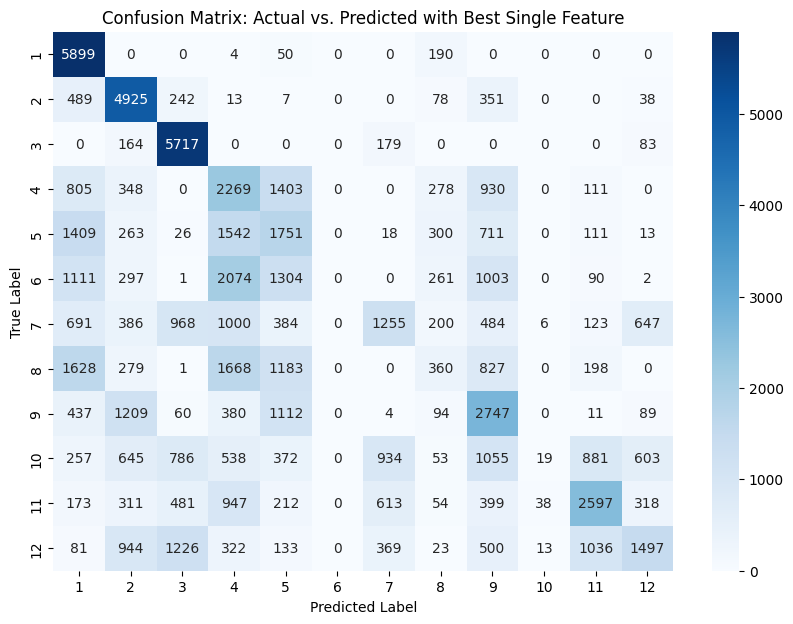

In [61]:
# Function to find the best single feature based on accuracy
def find_best_single_feature(importance_df, X_train, X_test, y_train, y_test, model):
    features = importance_df["Feature"].tolist()
    
    best_feature = None
    best_accuracy = 0
    
    # Evaluate each feature individually
    for feature in features:
        X_train_selected = X_train[[feature]]
        X_test_selected = X_test[[feature]]
        
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = feature
    
    print(f"Best single feature: {best_feature} with accuracy: {best_accuracy:.4f}")
    return best_feature

# Find the best single feature
best_1_feature = find_best_single_feature(importance_df, X_train, X_test, y_train, y_test, minimal_ensemble_model)

# Train the model using only the best feature
X_1_train_selected = X_train[[best_1_feature]]
X_1_test_selected = X_test[[best_1_feature]]

# Create Voting Classifier with both models
single_feature_ensemble_model = VotingClassifier(
    estimators=[('random_forest', ensable_rf_model), ('xgboost', ensable_xgb_model)],
    voting='soft'  # Use soft voting (probabilities) for better accuracy
)

single_feature_ensemble_model.fit(X_1_train_selected, y_train)

# Predict on test data
y_single_feature_pred_test = single_feature_ensemble_model.predict(X_1_test_selected)

# Evaluate final model performance
single_feature_test_accuracy = accuracy_score(y_test, y_single_feature_pred_test)
print(f"Accuracy with the best single feature ({best_1_feature}): {single_feature_test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_single_feature_pred_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Actual vs. Predicted with Best Single Feature")
plt.show()

From the provided data the best sensor placement seems to be the accellerometer on the right low arm, however the precision is very low as can be seen in the confusion matrix. 

Even so if we were to have the possibility of joining the accelleration and gyroscope data in a single sensor, like it is in most IMUs, and by looking at the weight of the features used, I would guess the chest placement to be the most accurate as the feature chest acc on the z axis is the most used with a weight of: 0.13 (13%) which is almost double that of the second feature on the importance list. Therefore if we join the missing gyro data from the chest to the acc I think that one sensor could be accurate enough to have acheive a good precision score.

## Results and Discussion

I will now validate the results with the validation data separated at the beggining of the assignment. First I will load all the models created. And then validate both their accuracy score, and all the evaluations done by the classification report method on the validation data separaterd at the beggining of the assignment.

['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'lank_acc__x', 'lank_acc__y', 'lank_acc__z', 'lank_gyr_x', 'lank_gyr_y', 'lank_gyr_z', 'mag_lank_x', 'mag_lank_y', 'mag_lank_z', 'rlowarm_acc_x', 'rlowarm_acc_y', 'rlowarm_acc_z', 'rlowarm_gyr_x', 'rlowarm_gyr_y', 'rlowarm_gyr_z', 'mag_rlowarm_x', 'mag_rlowarm_y', 'mag_rlowarm_z']


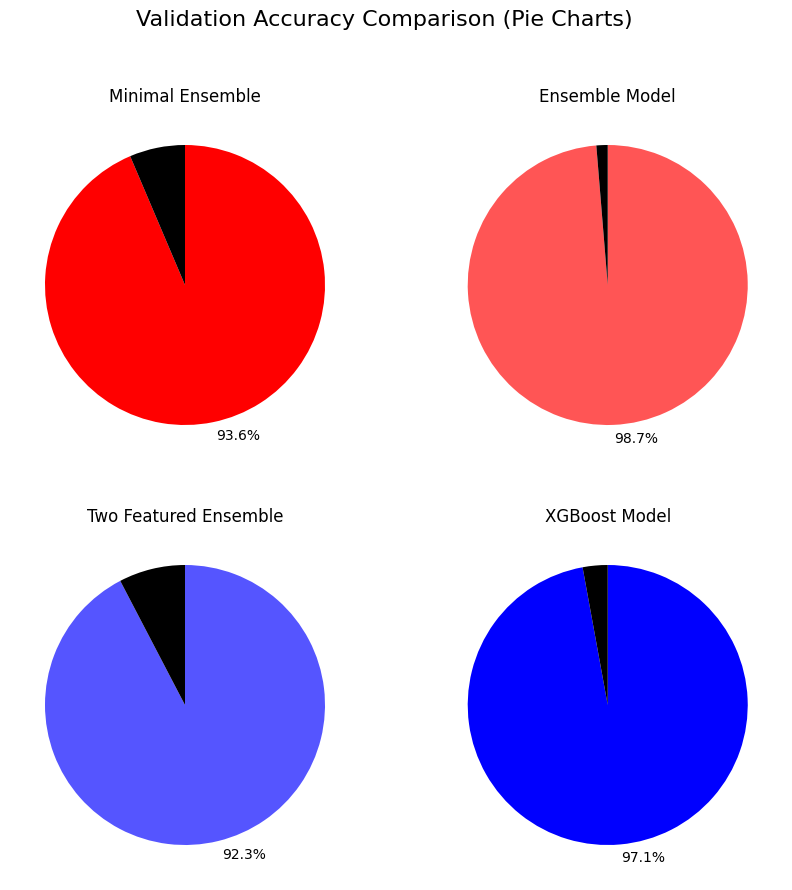

In [51]:
minimal_ensemble_model = joblib.load('Models/minimal_ensemble_model.pkl')
ensemble_model = joblib.load('Models/ensemble_model.pkl')
Two_featured_ensemble_model = joblib.load('Models/Two_featured_ensemble_model.pkl')
xgboost_model = joblib.load('Models/xgboost_model.pkl')
print(X_val.columns.tolist())
top10_selected_features = [
    'chest_acc_z',
    'rlowarm_acc_y',
    'rlowarm_acc_x',
    'lank_acc__z',
    'lank_acc__y',
    'rlowarm_gyr_x',
    'rlowarm_acc_z',
    'chest_acc_x',
    'mag_rlowarm_x',
    'rlowarm_gyr_y'
]
top2_selected_features = ['rlowarm_gyr_x', 'rlowarm_gyr_y', 'rlowarm_gyr_z', 'lank_gyr_z', 'lank_gyr_y', 'lank_gyr_x']



Two_X_val_selected = X_val[top2_selected_features]
Minimal_X_val_selected = X_val[top10_selected_features]


minimal_ensemble_y_val_pred = minimal_ensemble_model.predict(Minimal_X_val_selected)
ensemble_model_y_val_pred = ensemble_model.predict(X_val)
Two_featured_ensemble_model_y_val_pred = Two_featured_ensemble_model.predict(Two_X_val_selected)
xgboost_model_y_val_pred = xgboost_model.predict(X_val)

minimal_ensemble_y_val_accuracy = accuracy_score(y_val, minimal_ensemble_y_val_pred)
ensemble_model_y_val_accuracy = accuracy_score(y_val, ensemble_model_y_val_pred)
Two_featured_ensemble_model_y_val_accuracy = accuracy_score(y_val, Two_featured_ensemble_model_y_val_pred)
xgboost_model_y_val_accuracy = accuracy_score(y_val, xgboost_model_y_val_pred)

# Model names and corresponding accuracies (converted to percentage)
model_names = [
    'Minimal Ensemble', 
    'Ensemble Model', 
    'Two Featured Ensemble', 
    'XGBoost Model'
]

accuracies = [
    minimal_ensemble_y_val_accuracy * 100, 
    ensemble_model_y_val_accuracy * 100, 
    Two_featured_ensemble_model_y_val_accuracy * 100, 
    xgboost_model_y_val_accuracy * 100
]

# Create a 2x2 subplot for the 4 pie charts
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
colors = ['#FF0000', '#FF5555', '#5555FF', '#0000FF']  # Red to Blue gradient

# Generate the 4 pie charts
for i, ax in enumerate(axes):
    accuracy = accuracies[i]
    ax.pie(
        [accuracy, 100 - accuracy], 
        labels=[f'{accuracy:.1f}%', ''],
        colors=[colors[i], 'black'],  # Use gradient color for each pie
        startangle=90,
        counterclock=False
    )
    ax.set_title(model_names[i])

# Main title for the figure
plt.suptitle('Validation Accuracy Comparison (Pie Charts)', fontsize=16)
plt.show()


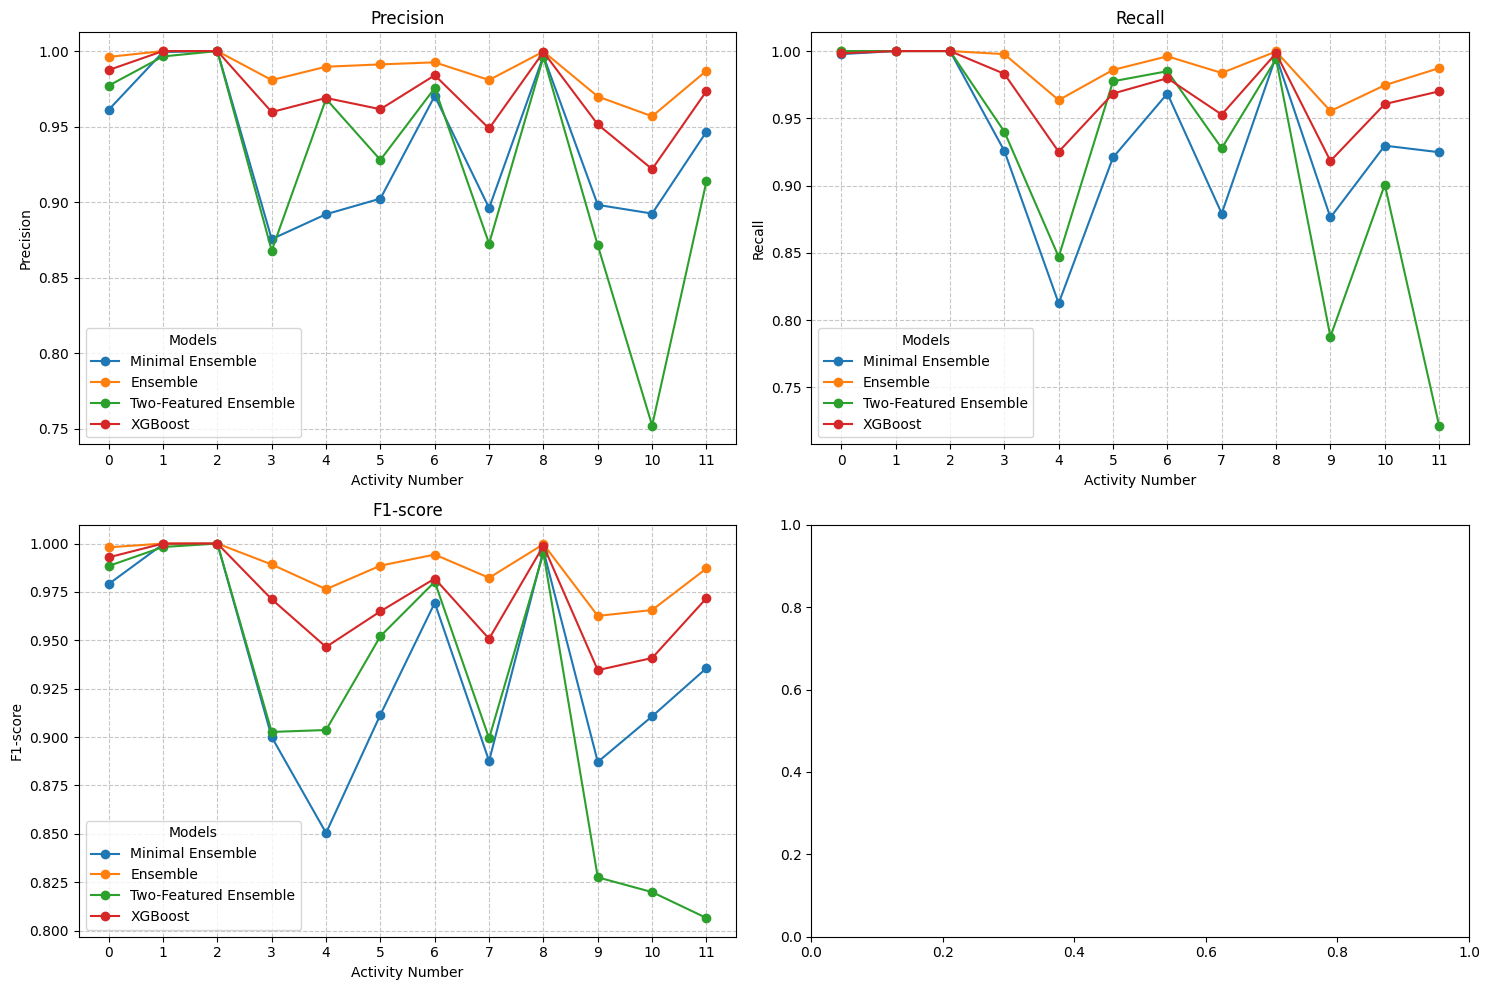

In [59]:
# Load the saved models
minimal_ensemble_model = joblib.load('Models/minimal_ensemble_model.pkl')
ensemble_model = joblib.load('Models/ensemble_model.pkl')
Two_featured_ensemble_model = joblib.load('Models/Two_featured_ensemble_model.pkl')
xgboost_model = joblib.load('Models/xgboost_model.pkl')

# Feature selection
top10_selected_features = [
    'chest_acc_z', 'rlowarm_acc_y', 'rlowarm_acc_x', 'lank_acc__z', 'lank_acc__y',
    'rlowarm_gyr_x', 'rlowarm_acc_z', 'chest_acc_x', 'mag_rlowarm_x', 'rlowarm_gyr_y'
]
top2_selected_features = ['rlowarm_gyr_x', 'rlowarm_gyr_y', 'rlowarm_gyr_z', 'lank_gyr_z', 'lank_gyr_y', 'lank_gyr_x']

Two_X_val_selected = X_val[top2_selected_features]
Minimal_X_val_selected = X_val[top10_selected_features]

# Make predictions
minimal_ensemble_y_val_pred = minimal_ensemble_model.predict(Minimal_X_val_selected)
ensemble_model_y_val_pred = ensemble_model.predict(X_val)
Two_featured_ensemble_model_y_val_pred = Two_featured_ensemble_model.predict(Two_X_val_selected)
xgboost_model_y_val_pred = xgboost_model.predict(X_val)

# Generate classification reports
models = {
    "Minimal Ensemble": minimal_ensemble_y_val_pred,
    "Ensemble": ensemble_model_y_val_pred,
    "Two-Featured Ensemble": Two_featured_ensemble_model_y_val_pred,
    "XGBoost": xgboost_model_y_val_pred
}

# Collect data for graphs
evaluation_metrics = ['precision', 'recall', 'f1-score']
report_data = {metric: {} for metric in evaluation_metrics}

for model_name, y_pred in models.items():
    report = classification_report(y_val, y_pred, output_dict=True)
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            for metric in evaluation_metrics:
                if model_name not in report_data[metric]:
                    report_data[metric][model_name] = []
                report_data[metric][model_name].append(metrics[metric])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
activity_labels = [str(i) for i in range(12)]  # Assuming activities are 0 to 11

# Color scheme for consistency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot each metric in a separate graph
for i, metric in enumerate(evaluation_metrics):
    ax = axes[i]
    for model_name, color in zip(models.keys(), colors):
        ax.plot(activity_labels, report_data[metric][model_name], marker='o', label=model_name, color=color)
    
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Activity Number')
    ax.set_ylabel(metric.capitalize())
    ax.legend(title='Models')
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

From the above graphs it is easy to see how the ensemble is crearly the best model out of all the tested, the "two feature ensable" has an extreme decrese in performance in the f1 score for the walking running and jumping back and forth, but does perform better then the minimal ensable for all activities except those, which seemps to be counter intuitive as its 2 features vs 10 used in the model trainig, but interesting to see.